# Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages and set up random seed

In [ ]:
import torch
import numpy as np
import random
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import gc

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

In [ ]:
seed = 42
set_seed(seed)

# Set up torch transformer

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #as pre-train used
])

In [ ]:
data_dir = '/content/drive/MyDrive/image_class_task_dataset'
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
valid_dataset = datasets.ImageFolder(root=f'{data_dir}/valid', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

# Prepare For Training used fucntion here

In [ ]:
def calculate_class_weights(dataset):
    num_classes = len(set(dataset.targets))
    class_counts = [0] * num_classes
    
    for label in dataset.targets:
        class_counts[label] += 1

    # weight count for label amount
    weights = [1.0 / count if count > 0 else 0.0 for count in class_counts]
    class_weights = torch.tensor(weights, dtype=torch.float)
    class_weights = class_weights / class_weights.sum()  # normalization

    return class_weights

In [ ]:
# # define model
# def initialize_model(model_type, num_classes, use_dropout):
#     """set up model for different types"""
#     if model_type == 'resnet':
#         model = models.resnet18(weights='IMAGENET1K_V1')
#         num_ftrs = model.fc.in_features
#         model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(num_ftrs, num_classes)) if use_dropout else nn.Linear(num_ftrs, num_classes)

#     elif model_type == 'mobilenet':
#         model = models.mobilenet_v2(weights='IMAGENET1K_V1')
#         num_ftrs = model.classifier[1].in_features
#         model.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(num_ftrs, num_classes)) if use_dropout else nn.Linear(num_ftrs, num_classes)

#     elif model_type == 'alexnet':
#         model = models.alexnet(weights='IMAGENET1K_V1')
#         num_ftrs = model.classifier[6].in_features
#         model.classifier[6] = nn.Sequential(nn.Dropout(0.3), nn.Linear(num_ftrs, num_classes)) if use_dropout else nn.Linear(num_ftrs, num_classes)

#     else:
#         raise ValueError(f"Unsupported model type: {model_type}")

#     # forzen all layers
#     for param in model.parameters():
#         param.requires_grad = False

#     # unforzen classifier layer
#     if model_type == 'resnet':
#         for param in model.fc.parameters():
#             param.requires_grad = True
#     elif model_type == 'mobilenet':
#         for param in model.classifier.parameters():
#             param.requires_grad = True
#     elif model_type == 'alexnet':
#         for param in model.classifier[6].parameters():
#             param.requires_grad = True

#     return model.to(device)

In [ ]:
def train_and_validate(model, criterion, optimizer, train_loader, valid_loader, scheduler=None,
                       num_epochs=50, grad_clip=None, device='cpu'):

    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            #  clipping
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # average loss and acc per whole dataset
        train_loss = running_loss / total_train
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # validation step
        model.eval()
        valid_loss, correct_valid, total_valid = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_valid += (preds == labels).sum().item()
                total_valid += labels.size(0)

        # as above
        valid_loss /= total_valid
        valid_acc = 100 * correct_valid / total_valid
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        # print current progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_acc:.2f}%")

        # change lr if have
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(valid_loss)  #  validation loss for RLP
            else:
                scheduler.step()  # Step for other scheduler types

    return history

# Set up experimental 2 res-18

In [ ]:
batch_size = 32
learning_rate = 1e-3
model_type = 'resnet'
optimizer_type = 'SGD'
schedulers = ['None', 'CosineAnnealingLR', 'ReduceLROnPlateau']
weight_decay_options = [0, 5e-4]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_loader.dataset.classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
experiment_results_resnet_1 = []

In [ ]:
for weight_decay in weight_decay_options:
    for sched in schedulers:

        # ram lease for speed up
        torch.cuda.empty_cache()
        gc.collect()

        # reproducibility
        set_seed(42)

        #  model
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)  # change for the number of classes
        model = model.to(device)

        #  loss function
        criterion = nn.CrossEntropyLoss()

        #  optimizer
        if optimizer_type == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

        #  scheduler
        if sched == 'CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        elif sched == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
        else:
            scheduler = None

        #  current configuration
        print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={learning_rate}, "
              f"Optimizer={optimizer_type}, Weight Decay={weight_decay}, Scheduler={sched}\n")

        # train and validate
        history = train_and_validate(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            valid_loader=valid_loader,
            scheduler=scheduler,
            num_epochs=100,
            grad_clip=None,
            device=device
        )

        # record results
        experiment_results_resnet_1.append({
            'model_type': model_type,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'optimizer_type': optimizer_type,
            'weight_decay': weight_decay,
            'scheduler': sched,
            'history': history
        })


Training resnet with Batch Size=32, LR=0.001, Optimizer=SGD, Weight Decay=0.0005, Scheduler=None

Epoch [1/100], Train Loss: 1.4738, Train Acc: 21.13%, Valid Loss: 1.1899, Valid Acc: 58.54%
Epoch [2/100], Train Loss: 1.1315, Train Acc: 47.18%, Valid Loss: 1.2030, Valid Acc: 51.22%
Epoch [3/100], Train Loss: 1.0342, Train Acc: 58.45%, Valid Loss: 1.0407, Valid Acc: 73.17%
Epoch [4/100], Train Loss: 0.8574, Train Acc: 67.61%, Valid Loss: 0.8150, Valid Acc: 80.49%
Epoch [5/100], Train Loss: 0.7204, Train Acc: 73.24%, Valid Loss: 0.7001, Valid Acc: 78.05%
Epoch [6/100], Train Loss: 0.5849, Train Acc: 76.06%, Valid Loss: 0.4905, Valid Acc: 85.37%
Epoch [7/100], Train Loss: 0.4730, Train Acc: 87.32%, Valid Loss: 0.4748, Valid Acc: 82.93%
Epoch [8/100], Train Loss: 0.4330, Train Acc: 85.92%, Valid Loss: 0.4128, Valid Acc: 90.24%
Epoch [9/100], Train Loss: 0.3785, Train Acc: 90.85%, Valid Loss: 0.4248, Valid Acc: 92.68%
Epoch [10/100], Train Loss: 0.2952, Train Acc: 95.77%, Valid Loss: 0.3741

# # Save E2 result - Res

In [ ]:
import pandas as pd

In [ ]:
experiment_df_res = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'weight_decay': result['weight_decay'],
        'scheduler': result['scheduler'],
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_resnet_1
])

In [ ]:
# save per feature result
experiment_df_res.to_csv("experiment_results_res.csv", index=False)
print("Experiment results have been saved to experiment_results.csv")

Experiment results have been saved to experiment_results.csv


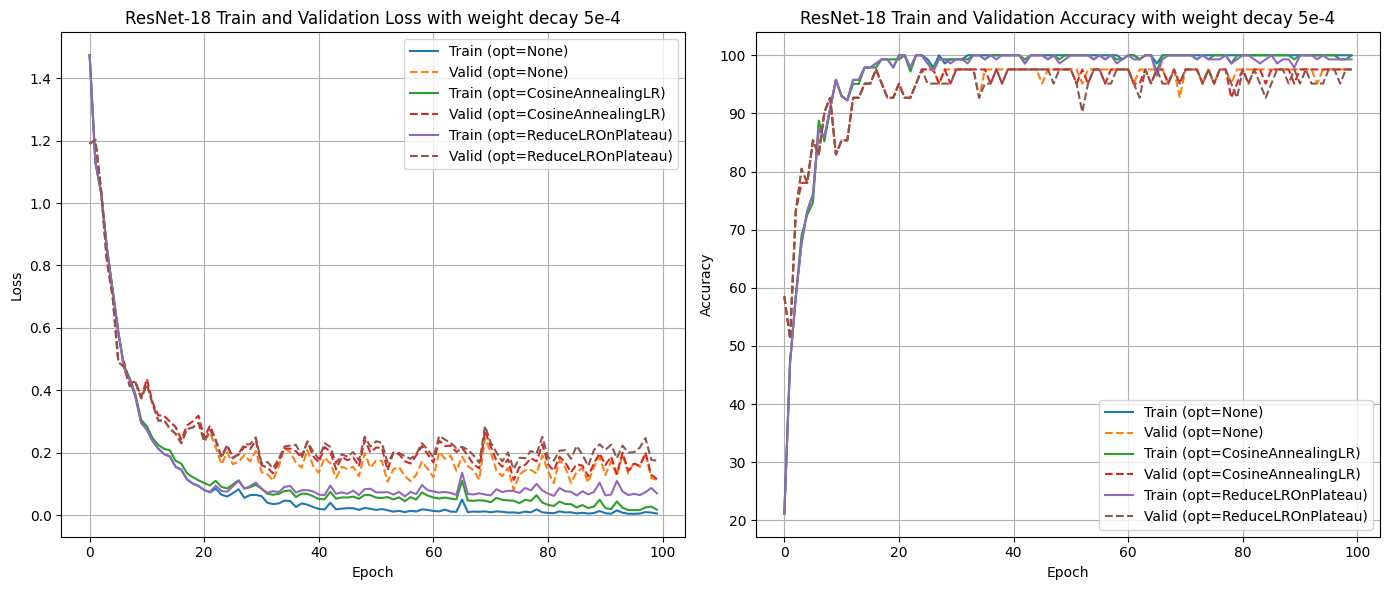

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#  train and validation loss
for i, row in experiment_df_res.iterrows():
    ax1.plot(row['train_loss'], label=f"Train (opt={row['scheduler']})", linestyle='-')
    ax1.plot(row['valid_loss'], label=f"Valid (opt={row['scheduler']})", linestyle='--')

ax1.set_title("ResNet-18 Train and Validation Loss with weight decay 5e-4")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

#  train and validation accuracy
for i, row in experiment_df_res.iterrows():
    ax2.plot(row['train_acc'], label=f"Train (opt={row['scheduler']})", linestyle='-')
    ax2.plot(row['valid_acc'], label=f"Valid (opt={row['scheduler']})", linestyle='--')

ax2.set_title("ResNet-18 Train and Validation Accuracy with weight decay 5e-4")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# work for res-18 check further optimizaiton method work or not

In [ ]:
#  fixed parameters
batch_size = 32
learning_rate = 1e-3
model_type = 'resnet'
optimizer_type = 'SGD'
scheduler_type = 'None'
weight_decay = 5e-4

In [106]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_loader.dataset.classes)

In [ ]:
#  variable parameters
grad_clips = [1.0]
use_class_weights_options = [False, True]
use_dropout_options = [True, False]

In [ ]:
# record for results
experiment_results_resnet_2 = []

In [ ]:
for grad_clip in grad_clips:
    for use_class_weights in use_class_weights_options:
        for use_dropout in use_dropout_options:

            torch.cuda.empty_cache()
            gc.collect()

            set_seed(42)

            model = models.resnet18(pretrained=True)
            num_ftrs = model.fc.in_features

            if use_dropout:
                model.fc = nn.Sequential(nn.Dropout(0.4), nn.Linear(num_ftrs, num_classes))
            else:
                model.fc = nn.Linear(num_ftrs, num_classes)  

            model = model.to(device)

            if use_class_weights:
                class_weights = calculate_class_weights(train_loader.dataset).to(device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)
            else:
                criterion = nn.CrossEntropyLoss()

            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

            scheduler = None

            print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={learning_rate}, "
                  f"Optimizer={optimizer_type}, Weight Decay={weight_decay}, Scheduler={scheduler_type}, "
                  f"Grad Clip={grad_clip}, Class Weights={use_class_weights}, Dropout={use_dropout}\n")

            history = train_and_validate(
                model=model,
                criterion=criterion,
                optimizer=optimizer,
                train_loader=train_loader,
                valid_loader=valid_loader,
                scheduler=scheduler,
                num_epochs=100,
                grad_clip=grad_clip,
                device=device
            )

            experiment_results_resnet_2.append({
                'model_type': model_type,
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer_type': optimizer_type,
                'weight_decay': weight_decay,
                'scheduler': scheduler_type,
                'grad_clip': grad_clip,
                'use_class_weights': use_class_weights,
                'use_dropout': use_dropout,
                'history': history
            })

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training resnet with Batch Size=32, LR=0.001, Optimizer=SGD, Weight Decay=0.0005, Scheduler=None, Grad Clip=1.0, Class Weights=False, Dropout=True

Epoch [1/100], Train Loss: 1.6606, Train Acc: 19.72%, Valid Loss: 1.4058, Valid Acc: 31.71%
Epoch [2/100], Train Loss: 1.5994, Train Acc: 20.42%, Valid Loss: 1.3461, Valid Acc: 26.83%
Epoch [3/100], Train Loss: 1.4987, Train Acc: 30.28%, Valid Loss: 1.2934, Valid Acc: 39.02%
Epoch [4/100], Train Loss: 1.3530, Train Acc: 35.21%, Valid Loss: 1.1295, Valid Acc: 41.46%
Epoch [5/100], Train Loss: 1.3026, Train Acc: 33.80%, Valid Loss: 1.1531, Valid Acc: 48.78%
Epoch [6/100], Train Loss: 1.2648, Train Acc: 44.37%, Valid Loss: 1.1073, Valid Acc: 51.22%
Epoch [7/100], Train Loss: 1.2283, Train Acc: 46.48%, Valid Loss: 1.1211, Valid Acc: 51.22%
Epoch [8/100], Train Loss: 1.1810, Train Acc: 45.77%, Valid Loss: 1.0617, Valid Acc: 60.98%
Epoch [9/100], Train Loss: 1.1829, Train Acc: 51.41%, Valid Loss: 1.0624, Valid Acc: 60.98%
Epoch [10/100], Train L

In [114]:
experiment_df_res_opt = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'weight_decay': result['weight_decay'],
        'scheduler': result['scheduler'],
        'grad_clip': result['grad_clip'],
        'use_class_weights': result['use_class_weights'],
        'use_dropout': result['use_dropout'],
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_resnet_2
])

In [111]:
experiment_df_res_opt.to_csv("experiment_results_res.csv", index=False)
print("Experiment results have been saved to experiment_results.csv")

Experiment results have been saved to experiment_results.csv


In [119]:
experiment_df_res.head()

,model_type,batch_size,learning_rate,optimizer_type,weight_decay,scheduler,train_loss,valid_loss,train_acc,valid_acc
0,resnet,32,0.001,SGD,0.0005,None,"[1.4738000446641948, 1.1314767145774733, 1.034...","[1.189944168416465, 1.2030199330027511, 1.0407...","[21.12676056338028, 47.183098591549296, 58.450...","[58.53658536585366, 51.21951219512195, 73.1707..."
1,resnet,32,0.001,SGD,0.0005,CosineAnnealingLR,"[1.4738000446641948, 1.1314621861551848, 1.034...","[1.189944168416465, 1.2024970694286068, 1.0409...","[21.12676056338028, 47.183098591549296, 58.450...","[58.53658536585366, 51.21951219512195, 73.1707..."
2,resnet,32,0.001,SGD,0.0005,ReduceLROnPlateau,"[1.4738000446641948, 1.1314767145774733, 1.034...","[1.189944168416465, 1.2030199330027511, 1.0407...","[21.12676056338028, 47.183098591549296, 58.450...","[58.53658536585366, 51.21951219512195, 73.1707..."


In [126]:
df_combined_res = pd.concat([experiment_df_res, experiment_df_res_opt], ignore_index=True)
df_combined_res.fillna(False, inplace=True)
df_combined_res.head(10)

<ipython-input-126-915560e9330a>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_combined_res.fillna(False, inplace=True)
<ipython-input-126-915560e9330a>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined_res.fillna(False, inplace=True)


,model_type,batch_size,learning_rate,optimizer_type,weight_decay,scheduler,train_loss,valid_loss,train_acc,valid_acc,grad_clip,use_class_weights,use_dropout
0,resnet,32,0.001,SGD,0.0005,None,"[1.4738000446641948, 1.1314767145774733, 1.034...","[1.189944168416465, 1.2030199330027511, 1.0407...","[21.12676056338028, 47.183098591549296, 58.450...","[58.53658536585366, 51.21951219512195, 73.1707...",False,False,False
1,resnet,32,0.001,SGD,0.0005,CosineAnnealingLR,"[1.4738000446641948, 1.1314621861551848, 1.034...","[1.189944168416465, 1.2024970694286068, 1.0409...","[21.12676056338028, 47.183098591549296, 58.450...","[58.53658536585366, 51.21951219512195, 73.1707...",False,False,False
2,resnet,32,0.001,SGD,0.0005,ReduceLROnPlateau,"[1.4738000446641948, 1.1314767145774733, 1.034...","[1.189944168416465, 1.2030199330027511, 1.0407...","[21.12676056338028, 47.183098591549296, 58.450...","[58.53658536585366, 51.21951219512195, 73.1707...",False,False,False
3,resnet,32,0.001,SGD,0.0005,None,"[1.6605663668941444, 1.599392487969197, 1.4986...","[1.4057752097525247, 1.3461263674061472, 1.293...","[19.718309859154928, 20.422535211267604, 30.28...","[31.70731707317073, 26.829268292682926, 39.024...",1.0,False,True
4,resnet,32,0.001,SGD,0.0005,None,"[1.5986857195975075, 1.4591218468169092, 1.367...","[1.3974397531369838, 1.32058233168067, 1.26349...","[14.084507042253522, 20.422535211267604, 34.50...","[31.70731707317073, 29.26829268292683, 36.5853...",1.0,False,False
5,resnet,32,0.001,SGD,0.0005,None,"[1.5996478493784514, 1.5442655069727294, 1.550...","[1.3943111402232473, 1.395800596330224, 1.3900...","[19.718309859154928, 16.901408450704224, 16.19...","[34.146341463414636, 26.829268292682926, 36.58...",1.0,True,True
6,resnet,32,0.001,SGD,0.0005,None,"[1.506323858046196, 1.4327978500178162, 1.4206...","[1.3877641631335746, 1.3758967736872232, 1.369...","[14.084507042253522, 11.971830985915492, 22.53...","[31.70731707317073, 26.829268292682926, 39.024...",1.0,True,False


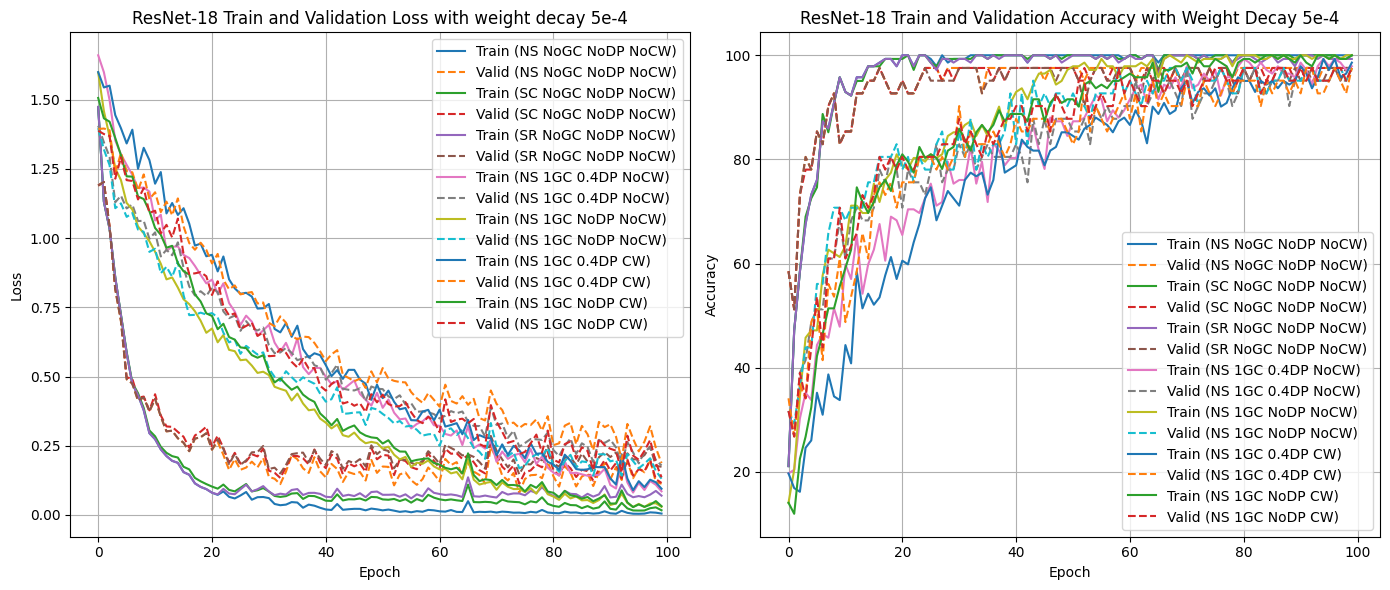

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# orignal too complex  change label here
scheduler_map = {'CosineAnnealingLR': 'SC', 'ReduceLROnPlateau': 'SR', None: 'NS'}
grad_clip_map = {False: 'NoGC', 1.0: '1GC'}
dropout_map = {False: 'NoDP', True: '0.4DP'}
classweight_map = {None: 'NoCW', True:'CW'}

for i, row in df_combined_res.iterrows():
    scheduler = scheduler_map.get(row['scheduler'], 'NS')
    grad_clip = grad_clip_map.get(row['grad_clip'], 'NoGC')
    dropout = dropout_map.get(row['use_dropout'], 'NoDP')  # Use .get with default value
    use_class_weights = classweight_map.get(row['use_class_weights'], 'NoCW')

    label = f"{scheduler} {grad_clip} {dropout} {use_class_weights}"

    ax1.plot(row['train_loss'], label=f"Train ({label})", linestyle='-')
    ax1.plot(row['valid_loss'], label=f"Valid ({label})", linestyle='--')

ax1.set_title("ResNet-18 Train and Validation Loss with weight decay 5e-4")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

for i, row in df_combined_res.iterrows():
    scheduler = scheduler_map.get(row['scheduler'], 'NS')
    grad_clip = grad_clip_map.get(row['grad_clip'], 'NoGC')
    dropout = dropout_map.get(row['use_dropout'], 'NoDP')  # Use .get with default value
    use_class_weights = classweight_map.get(row['use_class_weights'], 'NoCW')

    label = f"{scheduler} {grad_clip} {dropout} {use_class_weights}"

    ax2.plot(row['train_acc'], label=f"Train ({label})", linestyle='-')
    ax2.plot(row['valid_acc'], label=f"Valid ({label})", linestyle='--')

ax2.set_title("ResNet-18 Train and Validation Accuracy with Weight Decay 5e-4")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Start here work on alexnet

In [160]:
batch_size = 32
learning_rate = 1e-3
model_type = 'alexnet'
optimizer_type = 'Adam'
schedulers = ['CosineAnnealingLR', 'ReduceLROnPlateau']

In [161]:
set_seed(42)

In [162]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_loader.dataset.classes)

In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
experiment_results_alexnet_1 = []

In [ ]:
for sched in schedulers:

        torch.cuda.empty_cache()
        gc.collect()

        set_seed(42)

        model = models.alexnet(pretrained=True)
        num_ftrs = model.classifier[6].in_features

        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():
            param.requires_grad = True

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        if sched == 'CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
        elif sched == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
        else:
            scheduler = None

        print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={learning_rate}, "
              f"Optimizer={optimizer_type}, Scheduler={sched}\n")

        history = train_and_validate(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            valid_loader=valid_loader,
            scheduler=scheduler,
            num_epochs=50,
            grad_clip=None,
            device=device
        )

        experiment_results_alexnet_1.append({
            'model_type': model_type,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'optimizer_type': optimizer_type,
            'scheduler': sched,
            'history': history
        })


Training alexnet with Batch Size=32, LR=0.001, Optimizer=Adam, Scheduler=CosineAnnealingLR

Epoch [1/50], Train Loss: 1.1821, Train Acc: 49.30%, Valid Loss: 0.9246, Valid Acc: 60.98%
Epoch [2/50], Train Loss: 0.8818, Train Acc: 69.72%, Valid Loss: 0.6043, Valid Acc: 80.49%
Epoch [3/50], Train Loss: 0.6970, Train Acc: 71.13%, Valid Loss: 0.5287, Valid Acc: 80.49%
Epoch [4/50], Train Loss: 0.4925, Train Acc: 82.39%, Valid Loss: 0.4438, Valid Acc: 87.80%
Epoch [5/50], Train Loss: 0.5009, Train Acc: 83.10%, Valid Loss: 0.4639, Valid Acc: 78.05%
Epoch [6/50], Train Loss: 0.4312, Train Acc: 85.92%, Valid Loss: 0.3770, Valid Acc: 87.80%
Epoch [7/50], Train Loss: 0.3686, Train Acc: 85.21%, Valid Loss: 0.3331, Valid Acc: 85.37%
Epoch [8/50], Train Loss: 0.3156, Train Acc: 89.44%, Valid Loss: 0.3504, Valid Acc: 90.24%
Epoch [9/50], Train Loss: 0.3023, Train Acc: 89.44%, Valid Loss: 0.3145, Valid Acc: 85.37%
Epoch [10/50], Train Loss: 0.3498, Train Acc: 88.03%, Valid Loss: 0.3660, Valid Acc: 87.

In [166]:
experiment_df_alex_1 = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'scheduler': result['scheduler'],
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_alexnet_1
])

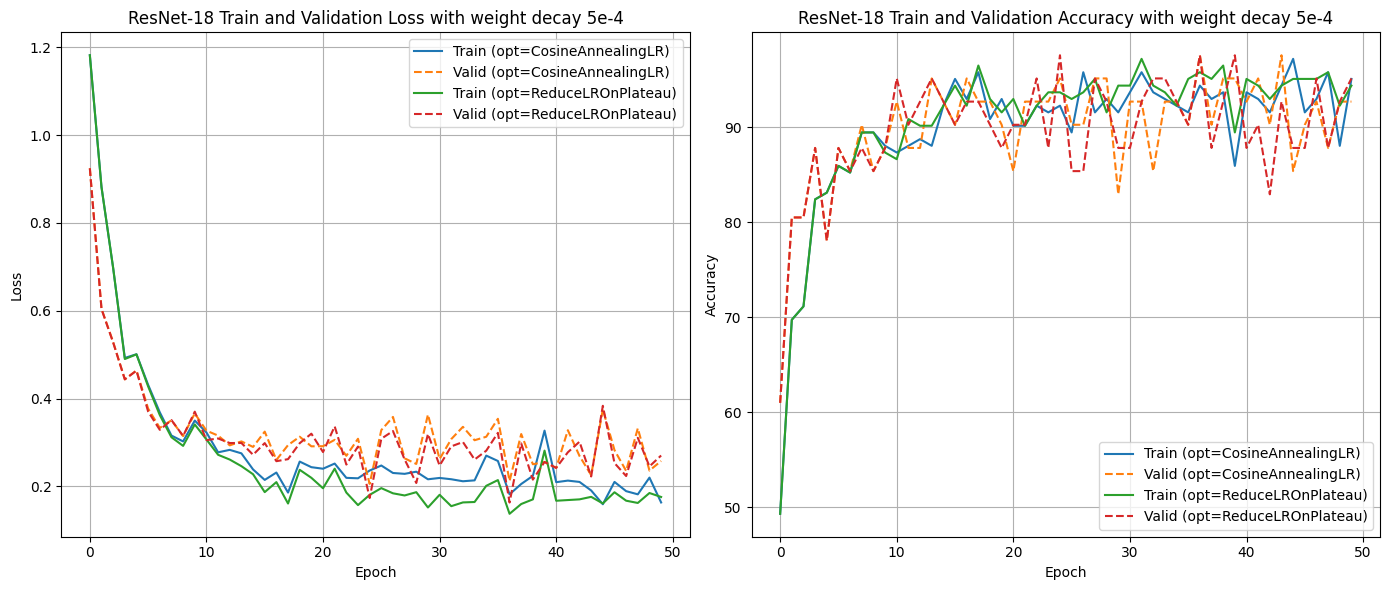

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#  train and validation loss
for i, row in experiment_df_alex_1.iterrows():
    ax1.plot(row['train_loss'], label=f"Train (opt={row['scheduler']})", linestyle='-')
    ax1.plot(row['valid_loss'], label=f"Valid (opt={row['scheduler']})", linestyle='--')

ax1.set_title("ResNet-18 Train and Validation Loss with weight decay 5e-4")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

#  train and validation accuracy
for i, row in experiment_df_alex_1.iterrows():
    ax2.plot(row['train_acc'], label=f"Train (opt={row['scheduler']})", linestyle='-')
    ax2.plot(row['valid_acc'], label=f"Valid (opt={row['scheduler']})", linestyle='--')

ax2.set_title("ResNet-18 Train and Validation Accuracy with weight decay 5e-4")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [174]:
batch_size = 32
learning_rate = 1e-3
model_type = 'alexnet'
optimizer_type = 'Adam'
schedulers = ['ReduceLROnPlateau']

In [175]:
set_seed(42)

In [176]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_loader.dataset.classes)

In [177]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [178]:
experiment_results_alexnet_2 = []

In [ ]:
for sched in schedulers:

        torch.cuda.empty_cache()
        gc.collect()

        set_seed(42)

        model = models.alexnet(pretrained=True)
        num_ftrs = model.classifier[6].in_features

        model.classifier[0] = nn.Dropout(0.3)
        model.classifier[3] = nn.Dropout(0.3)

        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():
            param.requires_grad = True

        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        if sched == 'CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
        elif sched == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
        else:
            scheduler = None

        print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={learning_rate}, "
              f"Optimizer={optimizer_type}, Scheduler={sched}\n")

        # Train and validate
        history = train_and_validate(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            valid_loader=valid_loader,
            scheduler=scheduler,
            num_epochs=50,
            grad_clip=1.0,
            device=device
        )

        experiment_results_alexnet_2.append({
            'model_type': model_type,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'optimizer_type': optimizer_type,
            'scheduler': sched,
            'dropout': 0.3,
            'grad_clip': 1.0,
            'history': history
        })

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training alexnet with Batch Size=32, LR=0.001, Optimizer=Adam, Scheduler=ReduceLROnPlateau

Epoch [1/50], Train Loss: 1.1793, Train Acc: 45.07%, Valid Loss: 0.8837, Valid Acc: 58.54%
Epoch [2/50], Train Loss: 0.7709, Train Acc: 73.24%, Valid Loss: 0.5618, Valid Acc: 80.49%
Epoch [3/50], Train Loss: 0.6058, Train Acc: 76.76%, Valid Loss: 0.4812, Valid Acc: 80.49%
Epoch [4/50], Train Loss: 0.3726, Train Acc: 85.92%, Valid Loss: 0.3877, Valid Acc: 90.24%
Epoch [5/50], Train Loss: 0.4187, Train Acc: 84.51%, Valid Loss: 0.4480, Valid Acc: 82.93%
Epoch [6/50], Train Loss: 0.3664, Train Acc: 87.32%, Valid Loss: 0.3366, Valid Acc: 87.80%
Epoch [7/50], Train Loss: 0.2861, Train Acc: 90.85%, Valid Loss: 0.2796, Valid Acc: 87.80%
Epoch [8/50], Train Loss: 0.2422, Train Acc: 91.55%, Valid Loss: 0.3293, Valid Acc: 87.80%
Epoch [9/50], Train Loss: 0.2073, Train Acc: 93.66%, Valid Loss: 0.2940, Valid Acc: 85.37%
Epoch [10/50], Train Loss: 0.2572, Train Acc: 90.14%, Valid Loss: 0.2956, Valid Acc: 92.

In [180]:
experiment_df_alex_2 = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'scheduler': result['scheduler'],
        'dropout': 0.3,
        'grad_clip:': 1.0,
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_alexnet_2
])

plot

In [198]:
df_combined_alex = pd.concat([experiment_df_alex_1, experiment_df_alex_2], ignore_index=True)
df_combined_alex.fillna(False, inplace=True)
df_combined_alex.columns

<ipython-input-198-6b3b2b0c9de5>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_combined_alex.fillna(False, inplace=True)


Index(['model_type', 'batch_size', 'learning_rate', 'optimizer_type',
       'scheduler', 'train_loss', 'valid_loss', 'train_acc', 'valid_acc',
       'dropout', 'grad_clip:'],
      dtype='object')

In [184]:
# df_combined_alex.to_csv("experiment_results_res.csv", index=False)
# print("Experiment results have been saved to experiment_results.csv")

Experiment results have been saved to experiment_results.csv


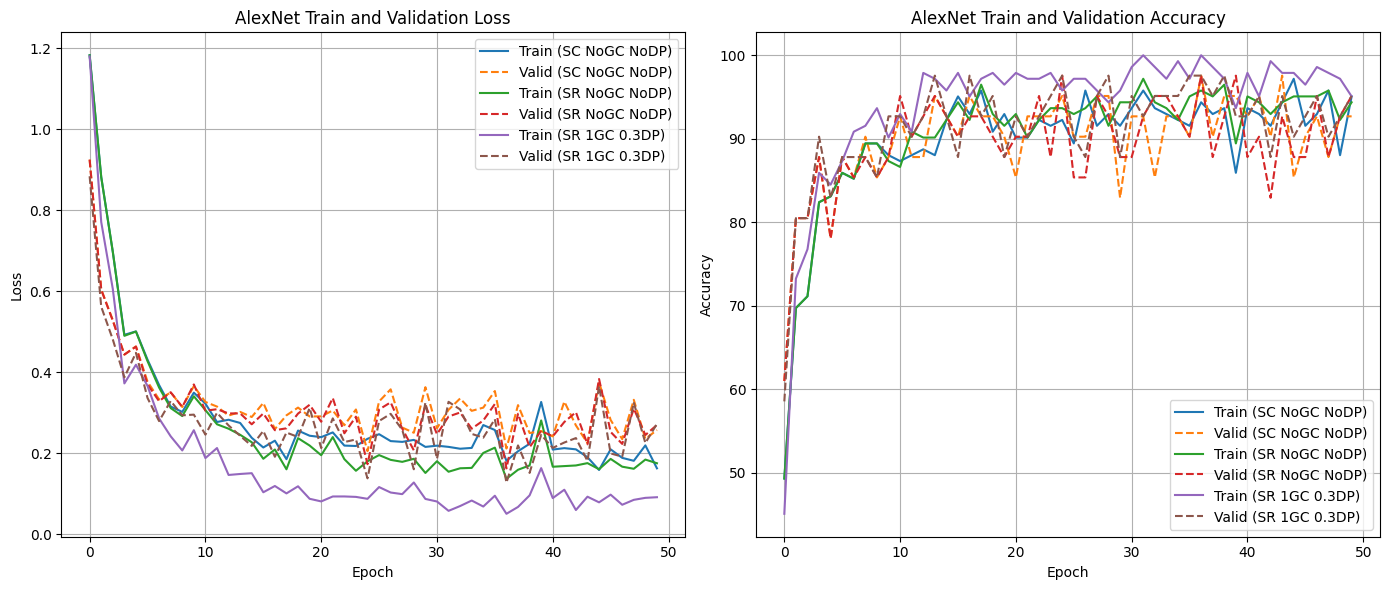

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

scheduler_map = {'CosineAnnealingLR': 'SC', 'ReduceLROnPlateau': 'SR'}
grad_clip_map = {'False': 'NoGC', 1.0: '1GC'}
dropout_map = {'False': 'NoDP', 0.3: '0.3DP'}

for i, row in df_combined_alex.iterrows():
    scheduler = scheduler_map.get(row.get('scheduler', 'SC'), 'SC')
    grad_clip = grad_clip_map.get(row.get('grad_clip:', 'NoGC'), 'NoGC')
    dropout = dropout_map.get(row.get('dropout', 'NoDP'), 'NoDP')

    label = f"{scheduler} {grad_clip} {dropout}"

    ax1.plot(row['train_loss'], label=f"Train ({label})", linestyle='-')
    ax1.plot(row['valid_loss'], label=f"Valid ({label})", linestyle='--')

ax1.set_title("AlexNet Train and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

for i, row in df_combined_alex.iterrows():
    scheduler = scheduler_map.get(row.get('scheduler', 'SC'), 'SC')
    grad_clip = grad_clip_map.get(row.get('grad_clip:', 'NoGC'), 'NoGC')
    dropout = dropout_map.get(row.get('dropout', 'NoDP'), 'NoDP')

    label = f"{scheduler} {grad_clip} {dropout}"

    ax2.plot(row['train_acc'], label=f"Train ({label})", linestyle='-')
    ax2.plot(row['valid_acc'], label=f"Valid ({label})", linestyle='--')

ax2.set_title("AlexNet Train and Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Mobilnet

In [ ]:
# mobilnet fixed
batch_size = 32
learning_rate = 1e-3
model_type = 'mobilenet'
optimizers = ['Adam', 'SGD']
schedulers = ['CosineAnnealingLR', 'ReduceLROnPlateau']

In [ ]:
set_seed(42)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_loader.dataset.classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

experiment_results_mobilenet_1 = []

In [ ]:
for optimizer_type in optimizers:
    for sched in schedulers:
        for unfreeze_all_layers in [True, False]:  # loop for traverse program

            torch.cuda.empty_cache()
            gc.collect()
            
            model = models.mobilenet_v2(pretrained=True)
            num_ftrs = model.classifier[1].in_features

            model.classifier[1] = nn.Linear(num_ftrs, num_classes)

            if unfreeze_all_layers:
                for param in model.parameters():
                    param.requires_grad = True
            else:
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.classifier[1].parameters():
                    param.requires_grad = True

            model = model.to(device)
            criterion = nn.CrossEntropyLoss()

            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

            if sched == 'CosineAnnealingLR':
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
            elif sched == 'ReduceLROnPlateau':
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
            else:
                scheduler = None

            freeze_status = "All Layers Unfrozen" if unfreeze_all_layers else "Only Last Layer Unfrozen"
            print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={learning_rate}, "
                  f"Optimizer={optimizer_type}, Scheduler={sched}, Freeze Status: {freeze_status}\n")

            history = train_and_validate(
                model=model,
                criterion=criterion,
                optimizer=optimizer,
                train_loader=train_loader,
                valid_loader=valid_loader,
                scheduler=scheduler,
                num_epochs=80,
                grad_clip=None,
                device=device
            )
            
            experiment_results_mobilenet_1.append({
                'model_type': model_type,
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer_type': optimizer_type,
                'scheduler': sched,
                'freeze_status': freeze_status,  # Record the freeze configuration
                'history': history
            })

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 216MB/s]



Training mobilenet with Batch Size=32, LR=0.001, Optimizer=Adam, Scheduler=CosineAnnealingLR, Freeze Status: All Layers Unfrozen

Epoch [1/80], Train Loss: 0.9622, Train Acc: 55.63%, Valid Loss: 1.0167, Valid Acc: 70.73%
Epoch [2/80], Train Loss: 0.4621, Train Acc: 80.99%, Valid Loss: 0.6699, Valid Acc: 85.37%
Epoch [3/80], Train Loss: 0.3100, Train Acc: 89.44%, Valid Loss: 0.3276, Valid Acc: 92.68%
Epoch [4/80], Train Loss: 0.2323, Train Acc: 93.66%, Valid Loss: 0.3242, Valid Acc: 90.24%
Epoch [5/80], Train Loss: 0.1366, Train Acc: 95.77%, Valid Loss: 0.6022, Valid Acc: 82.93%
Epoch [6/80], Train Loss: 0.1112, Train Acc: 96.48%, Valid Loss: 0.3762, Valid Acc: 87.80%
Epoch [7/80], Train Loss: 0.1225, Train Acc: 94.37%, Valid Loss: 0.5883, Valid Acc: 78.05%
Epoch [8/80], Train Loss: 0.1232, Train Acc: 96.48%, Valid Loss: 0.2484, Valid Acc: 87.80%
Epoch [9/80], Train Loss: 0.0640, Train Acc: 98.59%, Valid Loss: 0.1029, Valid Acc: 95.12%
Epoch [10/80], Train Loss: 0.1008, Train Acc: 95.0

In [206]:
experiment_df_mobile_1 = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'scheduler': result['scheduler'],
        'freeze_status': result['freeze_status'],
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_mobilenet_1
])

In [ ]:
# save result 
experiment_df_mobile_1.to_csv("experiment_results_res.csv", index=False)
print("Experiment results have been saved to experiment_results.csv")

Experiment results have been saved to experiment_results.csv


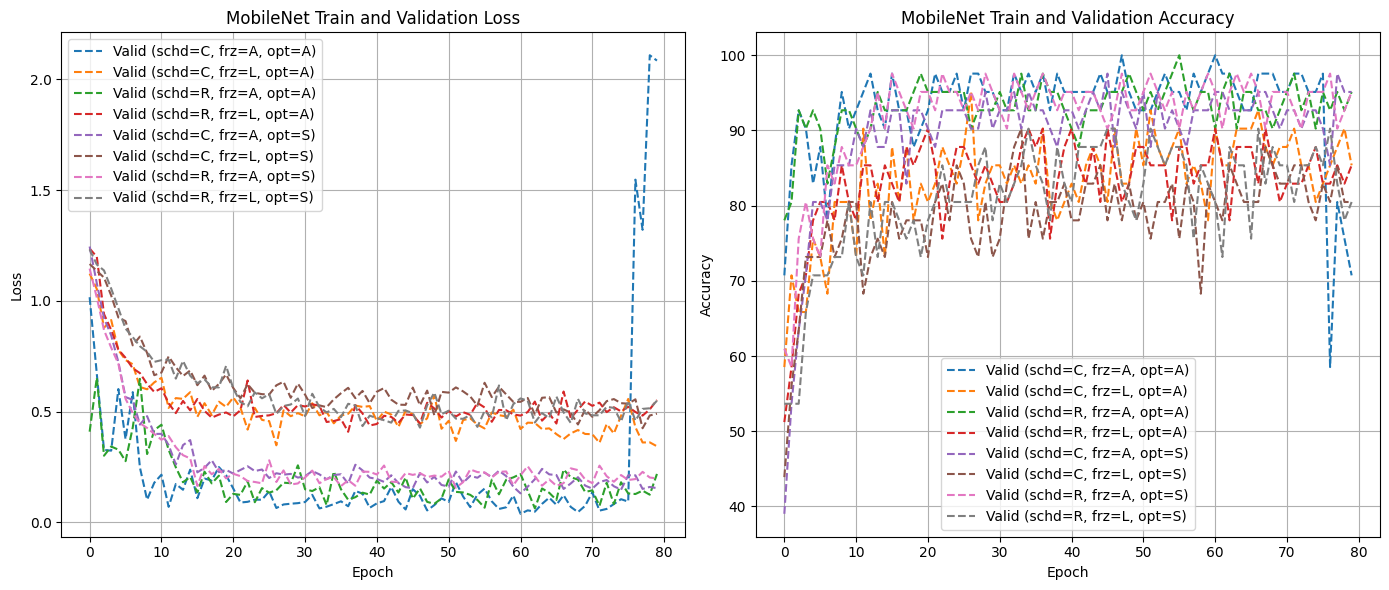

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#  train and validation loss
for i, row in experiment_df_mobile_1.iterrows():
    label = f"schd={row['scheduler'][0:1]}, frz={'A' if row['freeze_status'] == 'All Layers Unfrozen' else 'L'}, opt={row['optimizer_type'][0:1]}"
    # ax1.plot(row['train_loss'], label=f"Train ({label})", linestyle='-')
    ax1.plot(row['valid_loss'], label=f"Valid ({label})", linestyle='--')

ax1.set_title("MobileNet Train and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

#  train and validation accuracy
for i, row in experiment_df_mobile_1.iterrows():
    # Use the same compact label for accuracy plots
    label = f"schd={row['scheduler'][0:1]}, frz={'A' if row['freeze_status'] == 'All Layers Unfrozen' else 'L'}, opt={row['optimizer_type'][0:1]}"
    # ax2.plot(row['train_acc'], label=f"Train ({label})", linestyle='-')
    ax2.plot(row['valid_acc'], label=f"Valid ({label})", linestyle='--')

ax2.set_title("MobileNet Train and Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


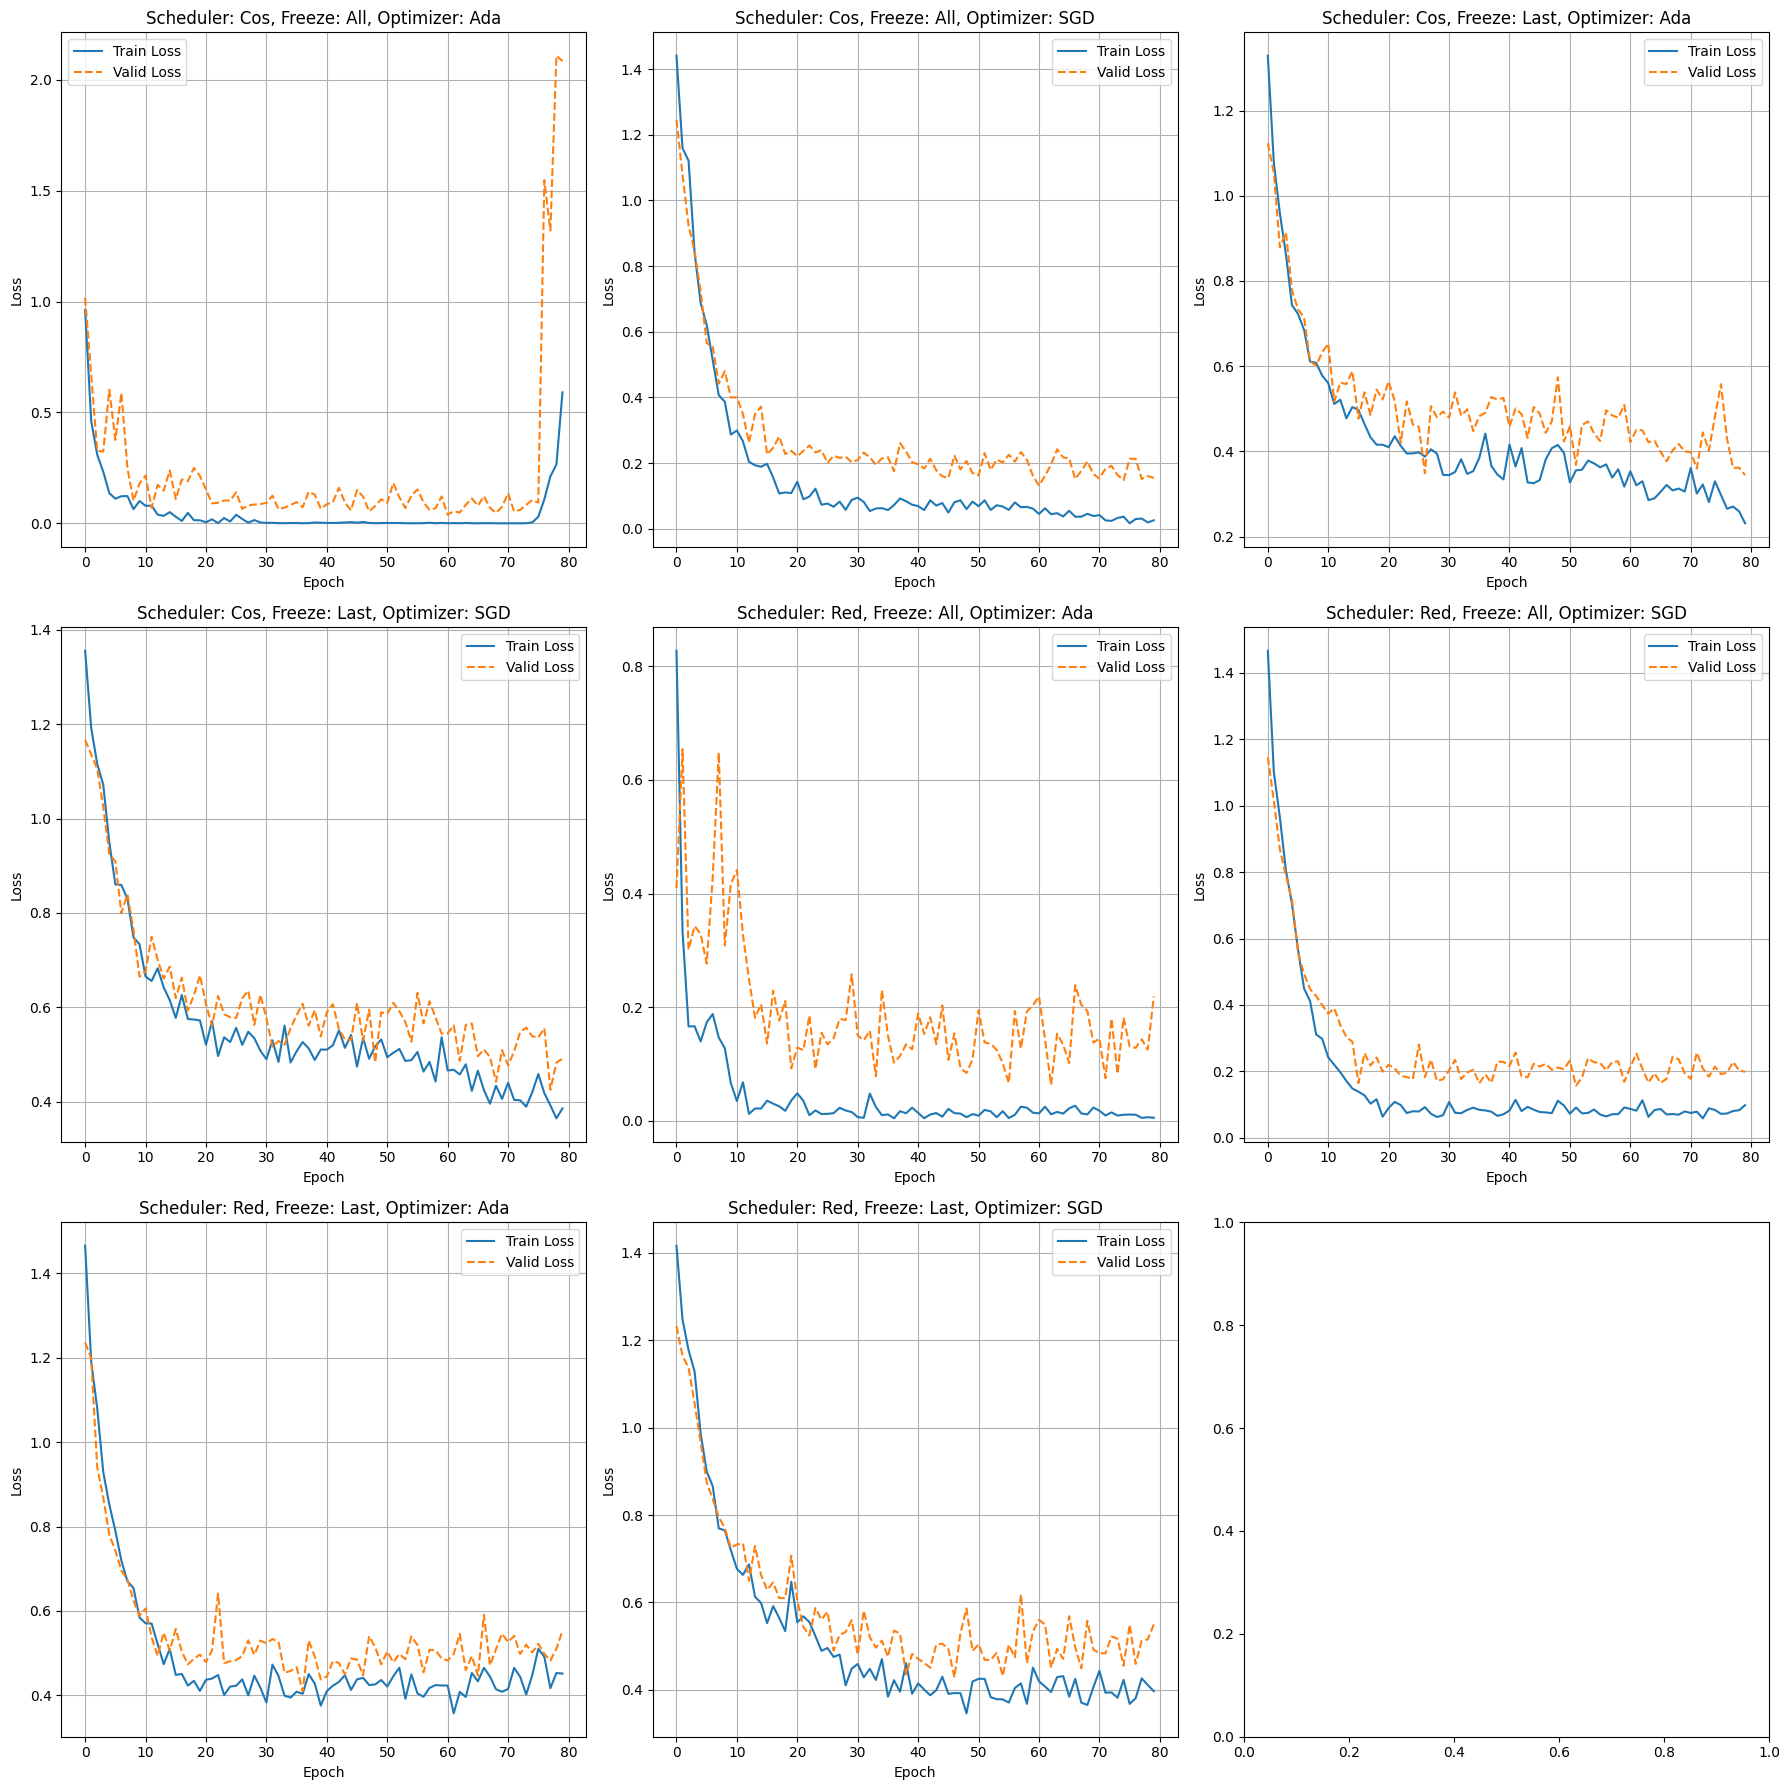

In [ ]:
schedulers = experiment_df_mobile_1['scheduler'].unique()
freeze_options = experiment_df_mobile_1['freeze_status'].unique()
optimizers = experiment_df_mobile_1['optimizer_type'].unique()

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()  # llatten 

plot_idx = 0

for scheduler in schedulers:
    for freeze_status in freeze_options:
        for optimizer_type in optimizers:

            filtered_data = experiment_df_mobile_1[
                (experiment_df_mobile_1['scheduler'] == scheduler) &
                (experiment_df_mobile_1['freeze_status'] == freeze_status) &
                (experiment_df_mobile_1['optimizer_type'] == optimizer_type)
            ]

            if filtered_data.empty:
                continue

            ax = axes[plot_idx]

            for i, row in filtered_data.iterrows():
                ax.plot(row['train_loss'], label="Train Loss", linestyle='-')
                ax.plot(row['valid_loss'], label="Valid Loss", linestyle='--')

            freeze_label = 'All' if freeze_status == 'All Layers Unfrozen' else 'Last'
            ax.set_title(f"Scheduler: {scheduler[:3]}, Freeze: {freeze_label}, Optimizer: {optimizer_type[:3]}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.legend()
            ax.grid(True)

            plot_idx += 1

plt.tight_layout()
plt.show()

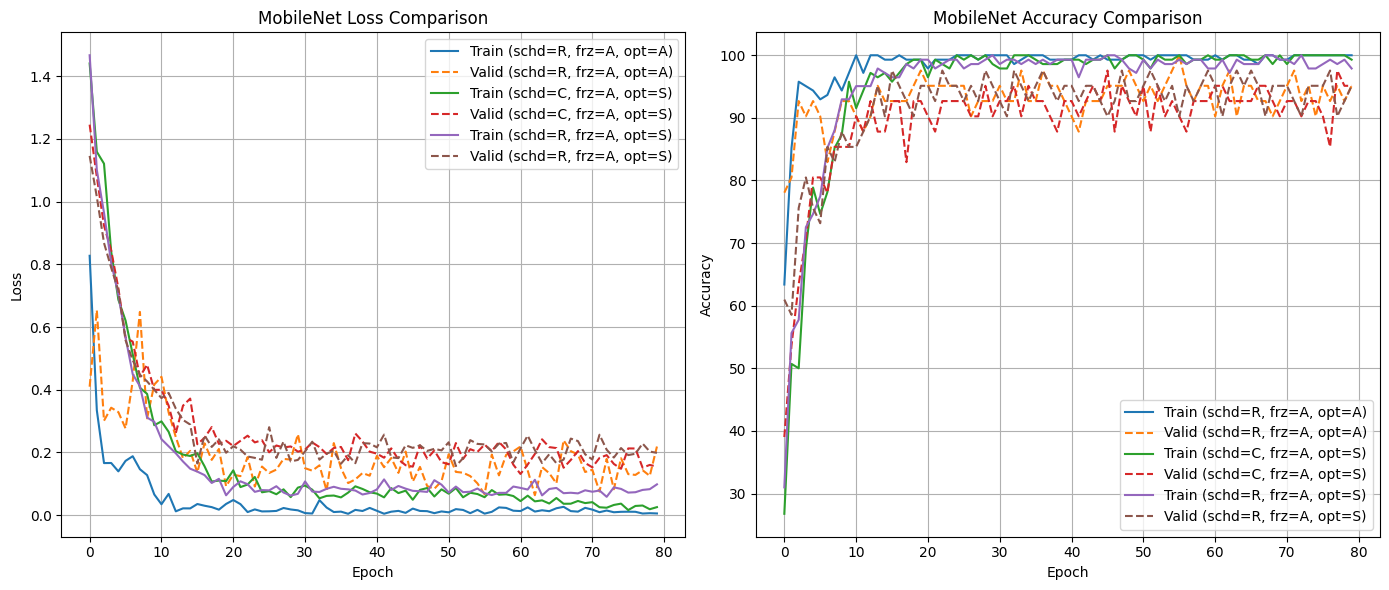

In [ ]:
configs_to_compare = [
    {"scheduler": "ReduceLROnPlateau", "freeze_status": "All Layers Unfrozen", "optimizer_type": "Adam"},
    {"scheduler": "CosineAnnealingLR", "freeze_status": "All Layers Unfrozen", "optimizer_type": "SGD"},
    {"scheduler": "ReduceLROnPlateau", "freeze_status": "All Layers Unfrozen", "optimizer_type": "SGD"}
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for config in configs_to_compare:

    filtered_data = experiment_df_mobile_1[
        (experiment_df_mobile_1['scheduler'] == config["scheduler"]) &
        (experiment_df_mobile_1['freeze_status'] == config["freeze_status"]) &
        (experiment_df_mobile_1['optimizer_type'] == config["optimizer_type"])
    ]

    scheduler_abbr = "R" if config["scheduler"] == "ReduceLROnPlateau" else "C"
    freeze_abbr = "A" if config["freeze_status"] == "All Layers Unfrozen" else "L"
    optimizer_abbr = "A" if config["optimizer_type"] == "Adam" else "S"

    label = f"schd={scheduler_abbr}, frz={freeze_abbr}, opt={optimizer_abbr}"

    for i, row in filtered_data.iterrows():
        ax1.plot(row['train_loss'], label=f"Train ({label})", linestyle='-')
        ax1.plot(row['valid_loss'], label=f"Valid ({label})", linestyle='--')

    for i, row in filtered_data.iterrows():
        ax2.plot(row['train_acc'], label=f"Train ({label})", linestyle='-')
        ax2.plot(row['valid_acc'], label=f"Valid ({label})", linestyle='--')

ax1.set_title("MobileNet Loss Comparison")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

ax2.set_title("MobileNet Accuracy Comparison")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()